In [18]:
import h5py
import numpy as np
import os,random
from tensorflow.keras.layers import Input,Reshape,ZeroPadding2D,MaxPool2D,Conv1D,Conv2D,Dropout,Flatten,Dense,Activation,MaxPooling2D,AlphaDropout
from tensorflow.keras import layers
import tensorflow.keras.models as Model
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [7]:
f = h5py.File('ExtractDataset/part0.h5')
sample_num = f['X'].shape[0]
# idx = np.random.choice(range(0,sample_num),size=3375)
idx = np.random.choice(range(0,sample_num),size=60000)
X = f['X'][:][idx]
Y = f['Y'][:][idx]
Z = f['Z'][:][idx]
f.close()

for i in range(1,24):
    if i%1 == 0:
        !free -m
    '''if i == 10:
        continue'''
    filename = 'ExtractDataset/part'+str(i) + '.h5'
    print(filename)
    f = h5py.File(filename,'r')
    X = np.vstack((X,f['X'][:][idx]))
    Y = np.vstack((Y,f['Y'][:][idx]))
    Z = np.vstack((Z,f['Z'][:][idx]))
    f.close()


print('X-size：',X.shape)
print('Y-size：',Y.shape)
print('Z-size：',Z.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


              total        used        free      shared  buff/cache   available
Mem:          64362        1918       54392          91        8051       61825
Swap:           976         860         116
ExtractDataset/part1.h5
              total        used        free      shared  buff/cache   available
Mem:          64362        2405       53904          91        8051       61337
Swap:           976         860         116
ExtractDataset/part2.h5
              total        used        free      shared  buff/cache   available
Mem:          64362        2898       53412          91        8051       60845
Swap:           976         860         116
ExtractDataset/part3.h5
              total        used        free      shared  buff/cache   available
Mem:          64362        3381       52929          91        8051       60362
Swap:           976         860         116
ExtractDataset/part4.h5
              total        used        free      shared  buff/cache   available
Mem:    

## Data preprocessing, and obtain training set and test set

In [8]:
n_examples = X.shape[0]
# n_train = int(n_examples * 0.9877) 
n_train = int(n_examples * 0.8)  
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)  #Randomly select training sample subscript
test_idx = list(set(range(0,n_examples))-set(train_idx)) #Test sample index
X_train = X[train_idx]  #training samples
X_test =  X[test_idx]  #testing samples
Y_train = Y[train_idx]
Y_test = Y[test_idx]
print("X_train:",X_train.shape)
print("Y_train:",Y_train.shape)
print("X_test:",X_test.shape)
print("Y_test:",Y_test.shape)

X_train: (1152000, 1024, 2)
Y_train: (1152000, 24)
X_test: (288000, 1024, 2)
Y_test: (288000, 24)


In [9]:
X_train[0]

array([[-0.69595945,  0.28230327],
       [-0.8029954 , -0.24903089],
       [ 0.13273656, -0.36350223],
       ...,
       [ 1.3612136 , -0.3556451 ],
       [ 1.5668713 , -0.46354663],
       [ 1.2725589 , -0.07846605]], dtype=float32)

In [16]:
X_train.shape[:1] 
# Input(in_shp)

(1152000,)

In [17]:
classes = ['32PSK',
 '16APSK',
 '32QAM',
 'FM',
 'GMSK',
 '32APSK',
 'OQPSK',
 '8ASK',
 'BPSK',
 '8PSK',
 'AM-SSB-SC',
 '4ASK',
 '16PSK',
 '64APSK',
 '128QAM',
 '128APSK',
 'AM-DSB-SC',
 'AM-SSB-WC',
 '64QAM',
 'QPSK',
 '256QAM',
 'AM-DSB-WC',
 'OOK',
 '16QAM']

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output
    
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
def proposed_model(X_train,classes):

    embed_dim = 2  # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer

#     inputs = layers.Input(shape=(maxlen,))
#     embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
#     x = embedding_layer(inputs)

    in_shp = X_train.shape[1:]   #Dimensions of each sample
    #input layer
    X_input = Input(in_shp)
    X = Reshape([1,1024,2], input_shape=in_shp)(X_input)
    
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(X)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    
    X = Dense(len(classes), kernel_initializer='he_normal', name="dense3")(x)
    #SoftMax
    X = Activation('softmax')(x)
    return tf.keras.models.Model(inputs=X_input, outputs=X)     
    
model = proposed_model(X_train,classes)    

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

ValueError: Input 0 of layer global_average_pooling1d is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [None, None, 1024, 2]

In [32]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [33]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
print(tf.test.gpu_device_name())

/device:GPU:0


In [34]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


In [35]:
%%time
filepath = 'proposed_model.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=1024,
    epochs=100,
    verbose=1,
#     validation_data=(X_test, Y_test),
    validation_split = 0.2,
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

Epoch 1/100
887/900 [============================>.] - ETA: 0s - loss: 2.6901 - accuracy: 0.1711
Epoch 00001: val_loss improved from inf to 2.50057, saving model to cnn_model.h5
900/900 [==============================] - 4s 4ms/step - loss: 2.6871 - accuracy: 0.1714 - val_loss: 2.5006 - val_accuracy: 0.1918
Epoch 2/100
889/900 [============================>.] - ETA: 0s - loss: 2.4247 - accuracy: 0.2144
Epoch 00002: val_loss improved from 2.50057 to 2.41155, saving model to cnn_model.h5
900/900 [==============================] - 3s 4ms/step - loss: 2.4244 - accuracy: 0.2145 - val_loss: 2.4116 - val_accuracy: 0.2145
Epoch 3/100
897/900 [============================>.] - ETA: 0s - loss: 2.3302 - accuracy: 0.2417
Epoch 00003: val_loss improved from 2.41155 to 2.37143, saving model to cnn_model.h5
900/900 [==============================] - 3s 4ms/step - loss: 2.3301 - accuracy: 0.2417 - val_loss: 2.3714 - val_accuracy: 0.2269
Epoch 4/100
893/900 [============================>.] - ETA: 0s - 

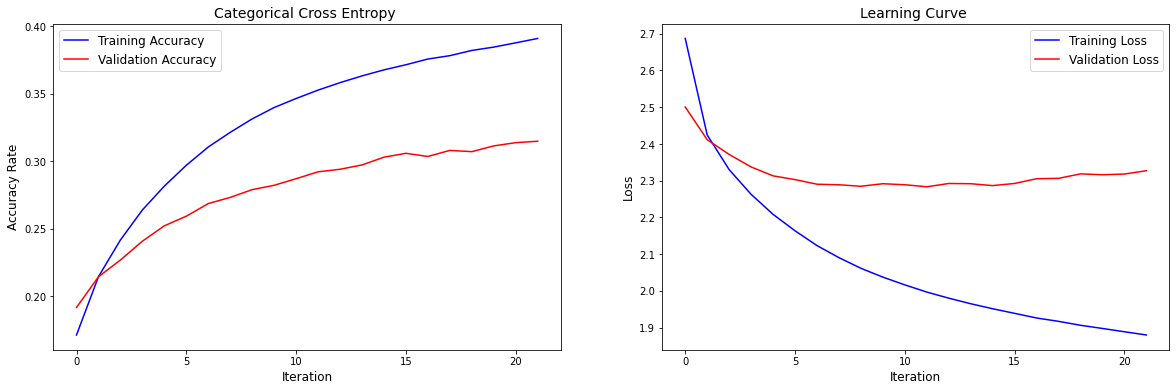

In [36]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

ax1.plot(history.history['accuracy'],'b', history.history['val_accuracy'], 'r')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title('Categorical Cross Entropy ',fontsize=14)
ax1.legend(['Training Accuracy','Validation Accuracy'],fontsize=12,loc='best')

ax2.plot(history.history['loss'], 'b',history.history['val_loss'],'r')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve ',fontsize=14)
ax2.legend(['Training Loss','Validation Loss'],fontsize=12,loc='best')

# plt.savefig('crosse_results.png')
plt.show()

In [37]:
model = load_model(filepath)

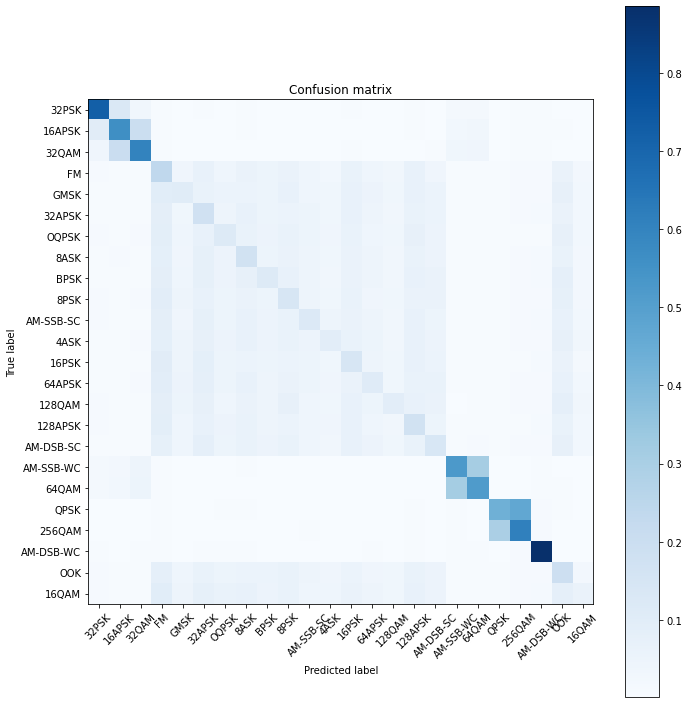

In [38]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Plot confusion matrix
batch_size = 1024
test_Y_hat = model.predict(X_test, batch_size=3000)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

In [39]:
for i in range(len(confnorm)):
    print(classes[i],confnorm[i,i])

32PSK 0.7259302519606208
16APSK 0.5635557785582873
32QAM 0.6017388396589199
FM 0.2388697912299824
GMSK 0.10232480626614449
32APSK 0.17442713854684824
OQPSK 0.11711559571054632
8ASK 0.1697893246731618
BPSK 0.11233498696712352
8PSK 0.1443012383118524
AM-SSB-SC 0.12100742223334167
4ASK 0.0936301484075371
16PSK 0.14505679427850232
64APSK 0.10809234102841904
128QAM 0.09134173833180262
128APSK 0.16727483828163875
AM-DSB-SC 0.13682092555331993
AM-SSB-WC 0.5250756770023726
64QAM 0.5182615963226076
QPSK 0.4348042056461628
256QAM 0.6103454001992693
AM-DSB-WC 0.8854592475181446
OOK 0.1905786902889312
16QAM 0.057956615333664516


In [40]:
Z_test

array([ -8,  -8, -10, ..., -18,  26, -14])

Overall Accuracy -20:  0.25955643707176346
Overall Accuracy -18:  0.27591304347826084
Overall Accuracy -16:  0.27615212527964206
Overall Accuracy -14:  0.2714673913043478
Overall Accuracy -12:  0.27795382526029877
Overall Accuracy -10:  0.2910230382204961
Overall Accuracy -8:  0.30786559038858646
Overall Accuracy -6:  0.3225553425135088
Overall Accuracy -4:  0.3101115377582739
Overall Accuracy -2:  0.3125503896801935


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Overall Accuracy 0:  0.2991191802984001
Overall Accuracy 2:  0.2793775044264281
Overall Accuracy 4:  0.2834616795012835
Overall Accuracy 6:  0.29148220293961397
Overall Accuracy 8:  0.29498967911428037
Overall Accuracy 10:  0.29528102290497654
Overall Accuracy 12:  0.30408983019901403
Overall Accuracy 14:  0.29785011750369916
Overall Accuracy 16:  0.30736168267032465
Overall Accuracy 18:  0.2949025887376568
Overall Accuracy 20:  0.2969921332716335
Overall Accuracy 22:  0.29612554304459615
Overall Accuracy 24:  0.2970942337286141
Overall Accuracy 26:  0.2976852682576709
Overall Accuracy 28:  0.2852650494159928
Overall Accuracy 30:  0.30284256559766765


<Figure size 432x288 with 0 Axes>

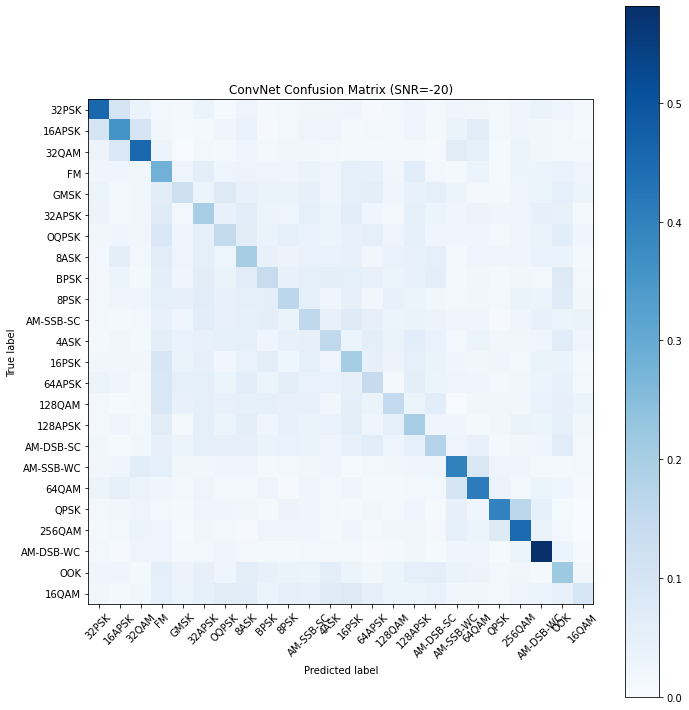

<Figure size 432x288 with 0 Axes>

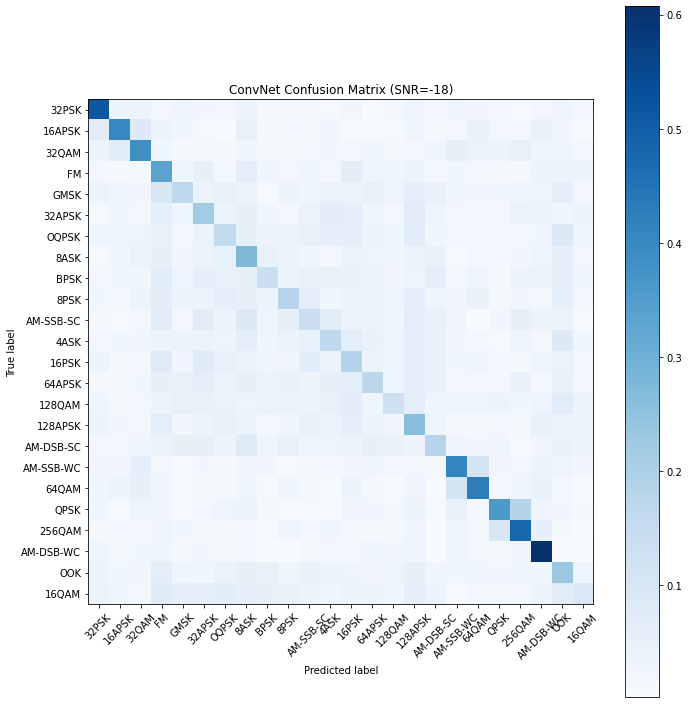

<Figure size 432x288 with 0 Axes>

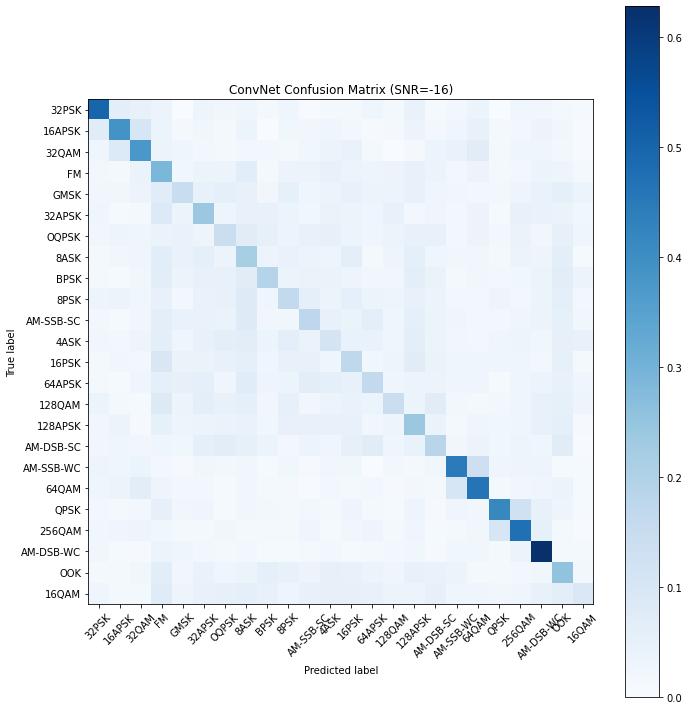

<Figure size 432x288 with 0 Axes>

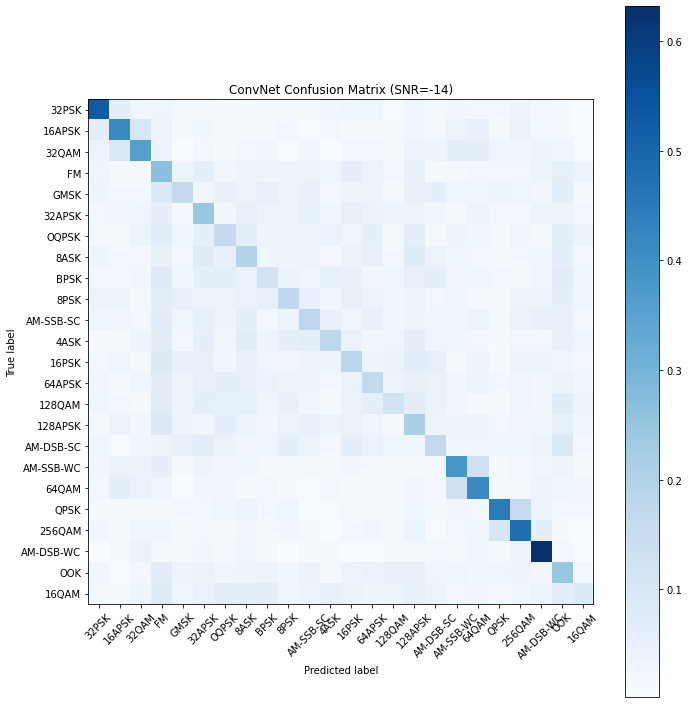

<Figure size 432x288 with 0 Axes>

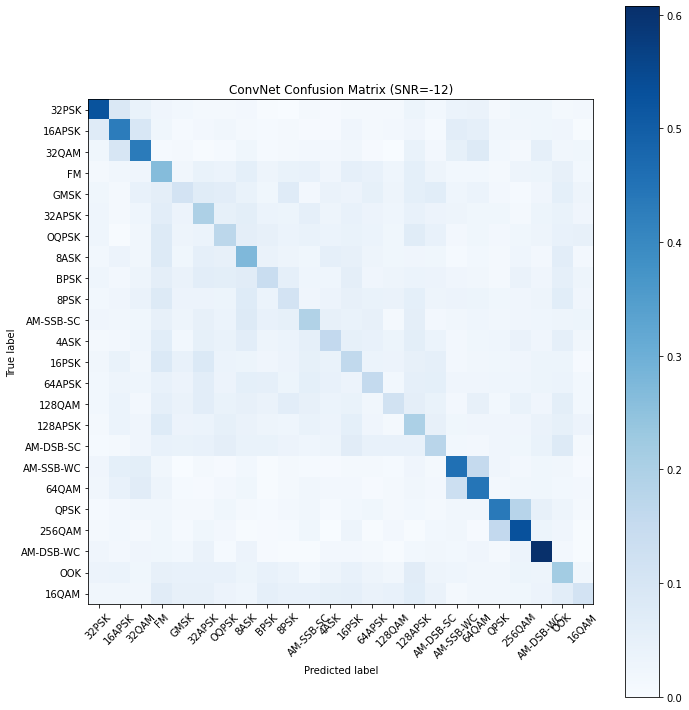

<Figure size 432x288 with 0 Axes>

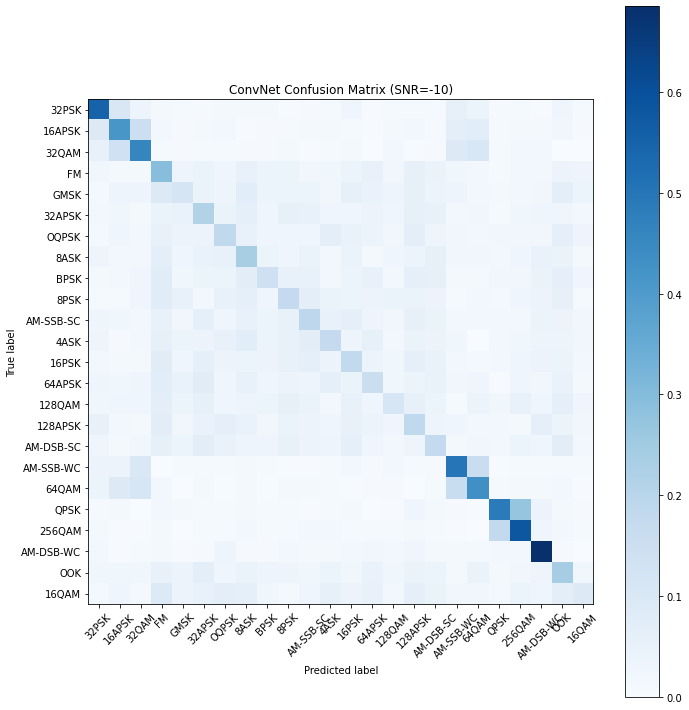

<Figure size 432x288 with 0 Axes>

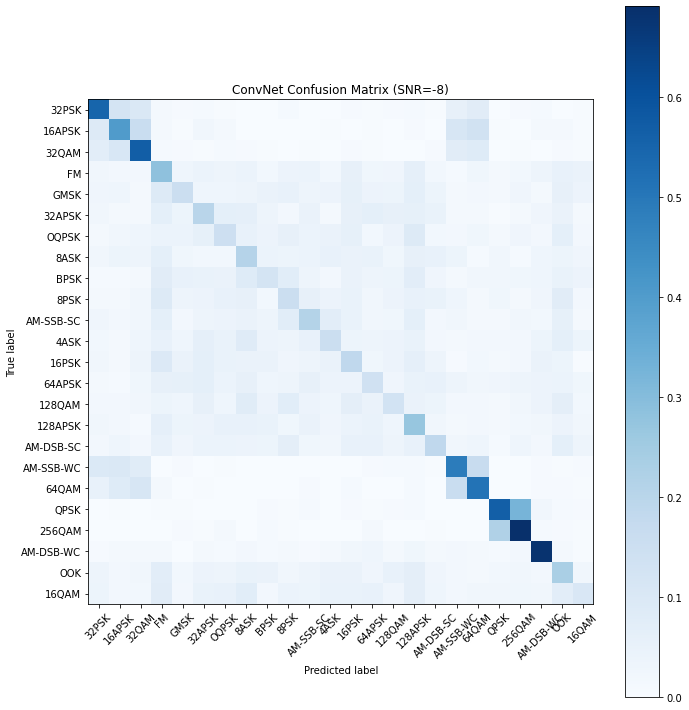

<Figure size 432x288 with 0 Axes>

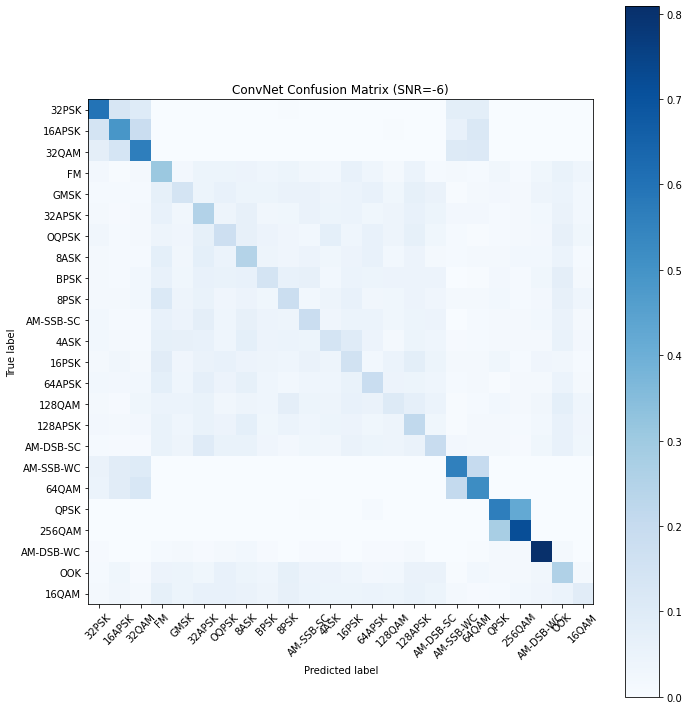

<Figure size 432x288 with 0 Axes>

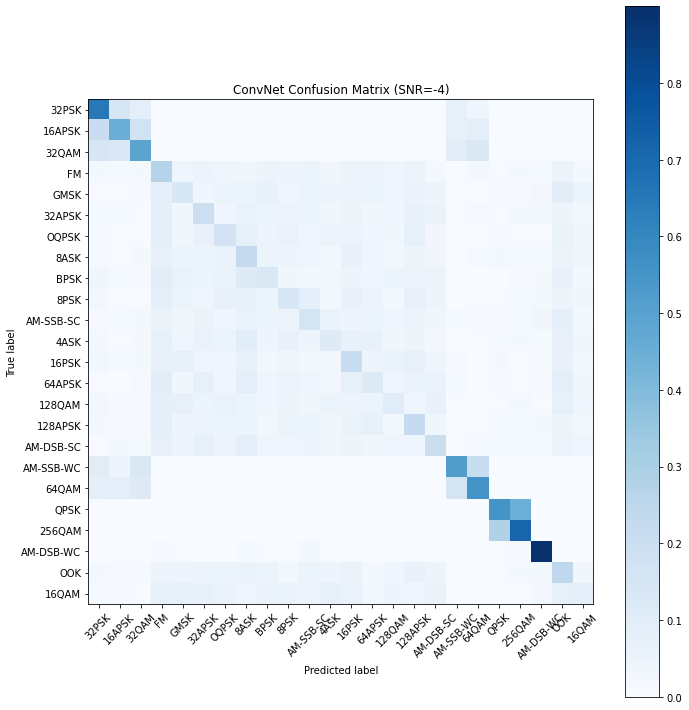

<Figure size 432x288 with 0 Axes>

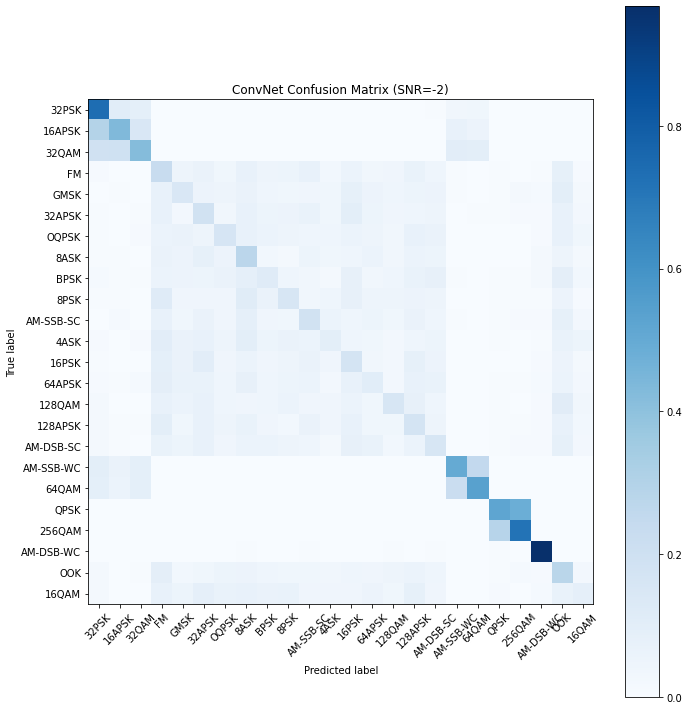

<Figure size 432x288 with 0 Axes>

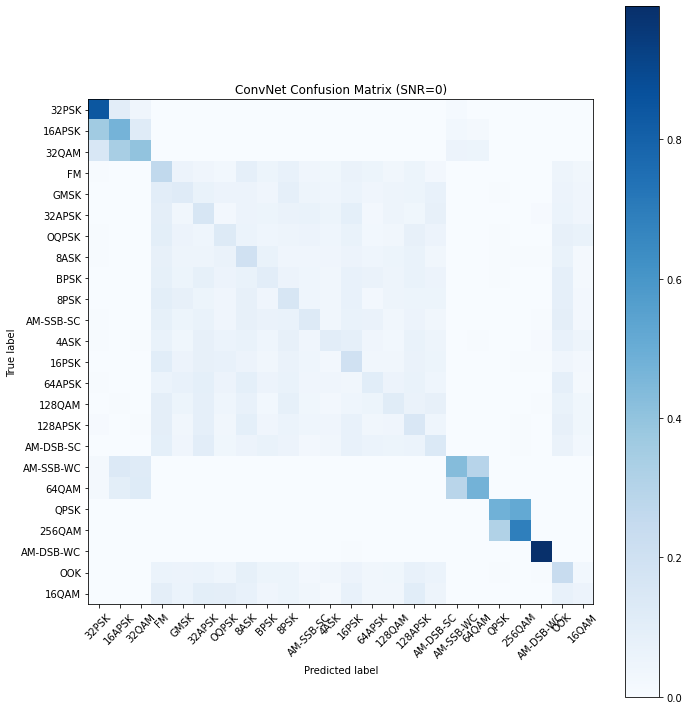

<Figure size 432x288 with 0 Axes>

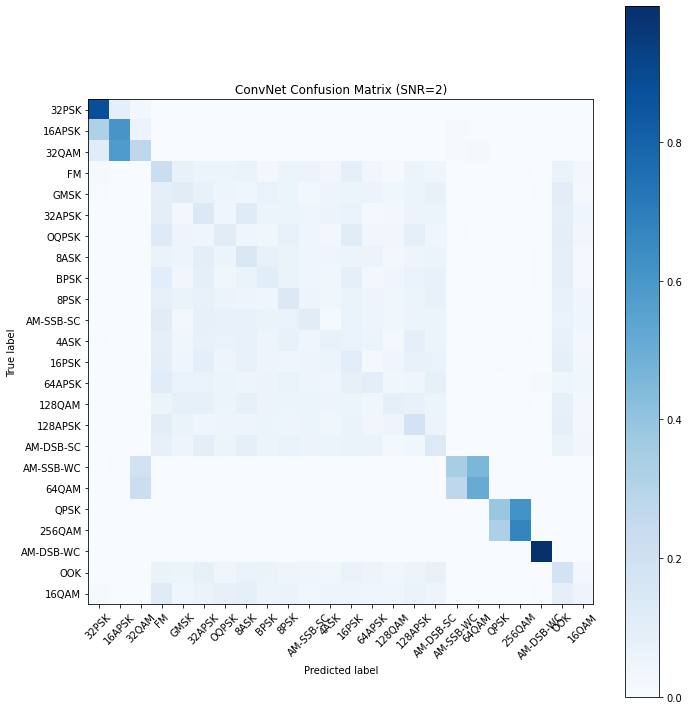

<Figure size 432x288 with 0 Axes>

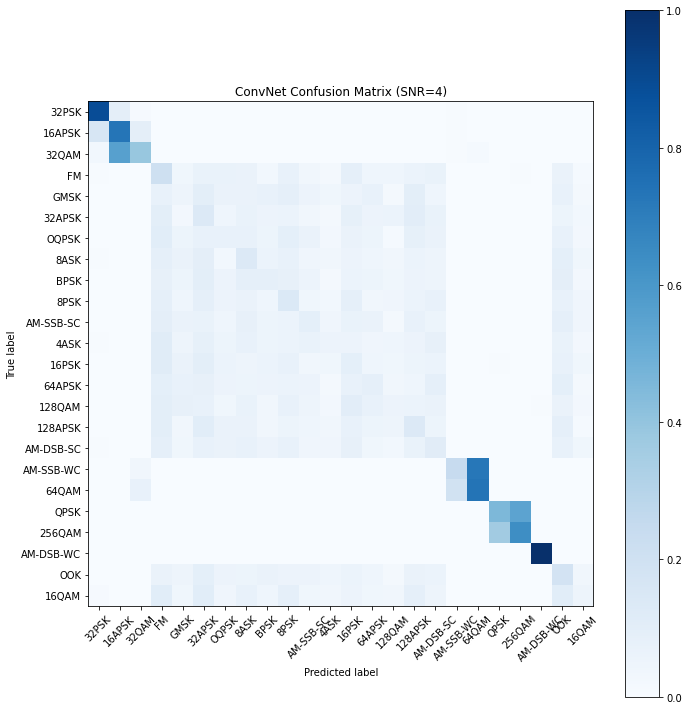

<Figure size 432x288 with 0 Axes>

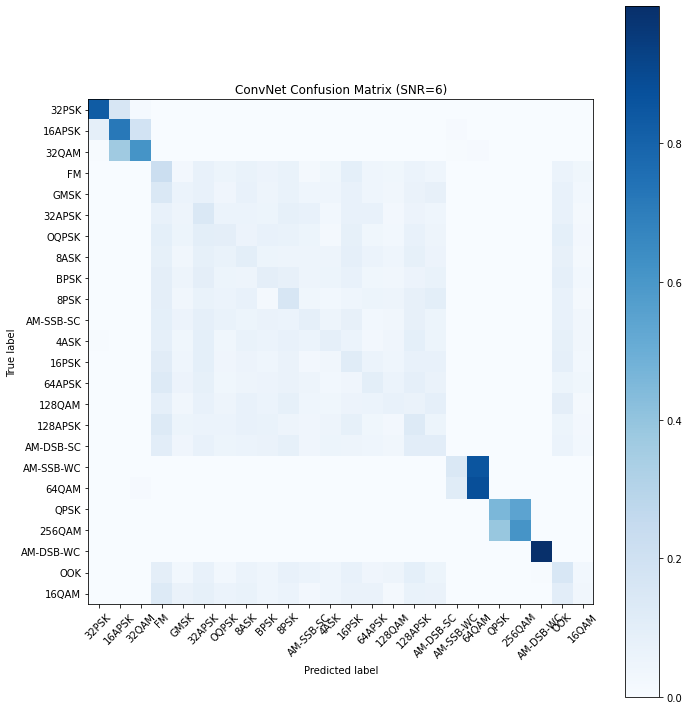

<Figure size 432x288 with 0 Axes>

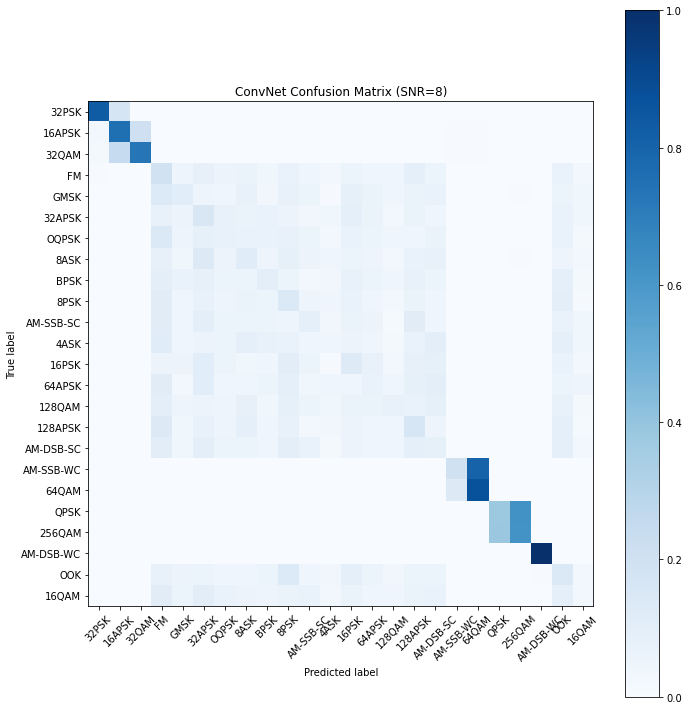

<Figure size 432x288 with 0 Axes>

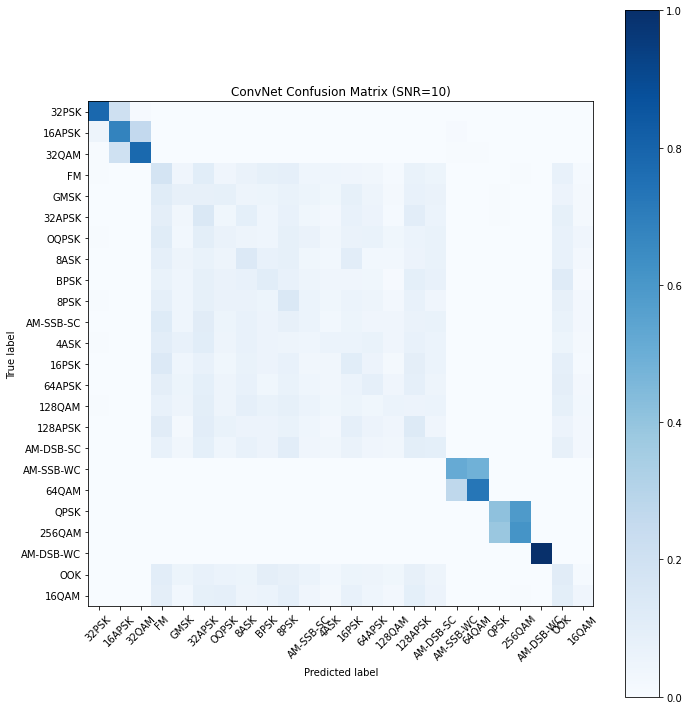

<Figure size 432x288 with 0 Axes>

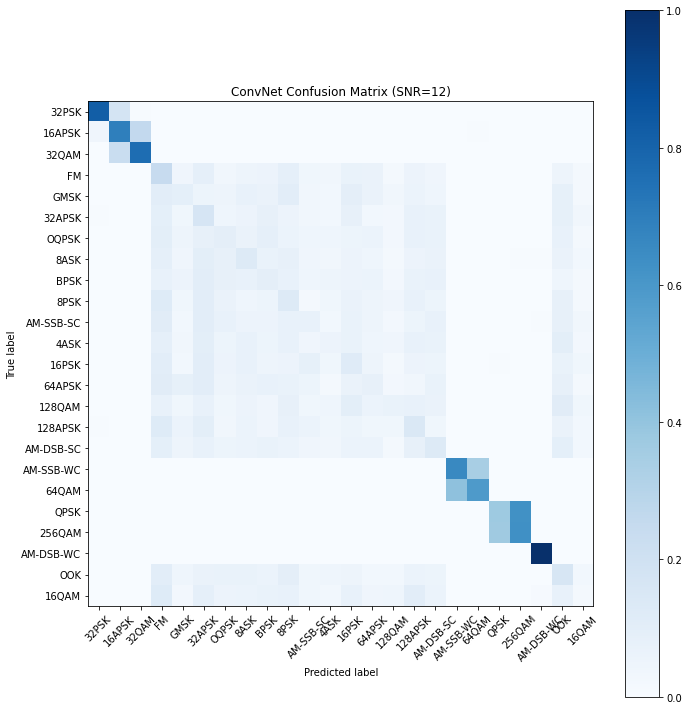

<Figure size 432x288 with 0 Axes>

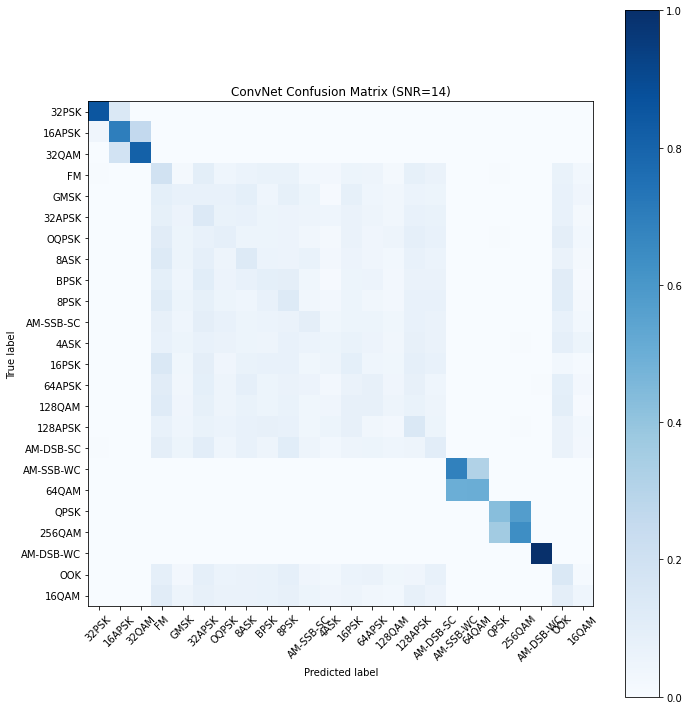

<Figure size 432x288 with 0 Axes>

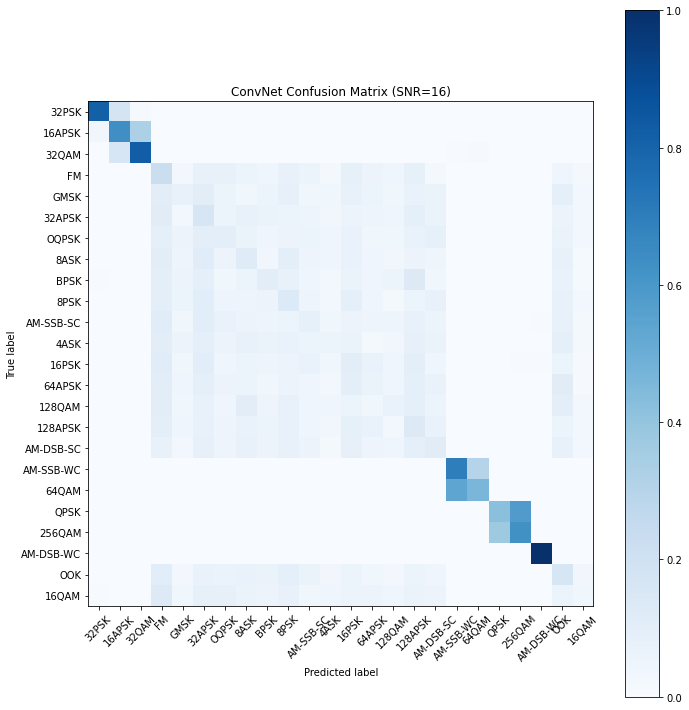

<Figure size 432x288 with 0 Axes>

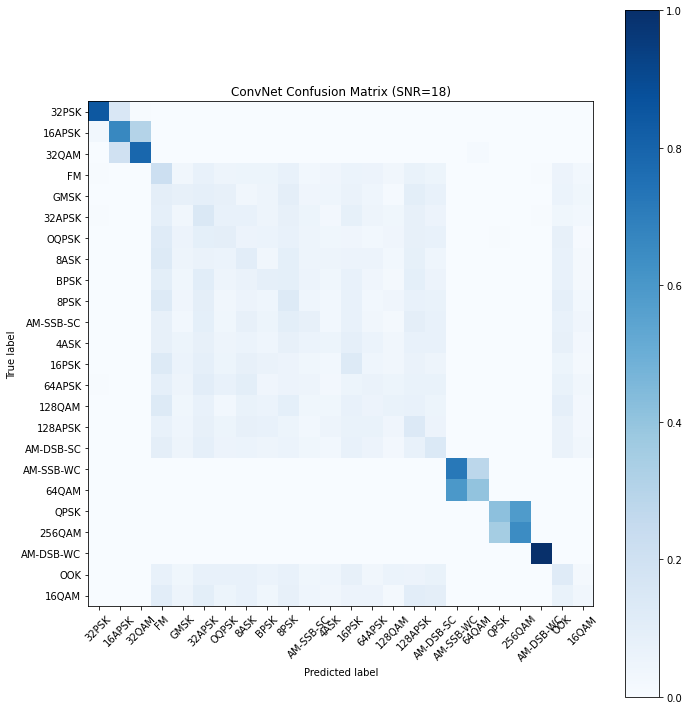

<Figure size 432x288 with 0 Axes>

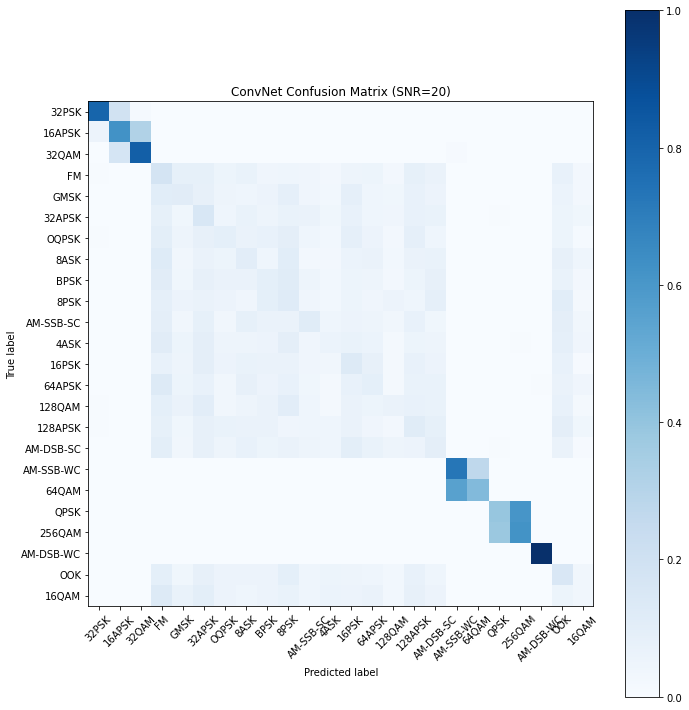

<Figure size 432x288 with 0 Axes>

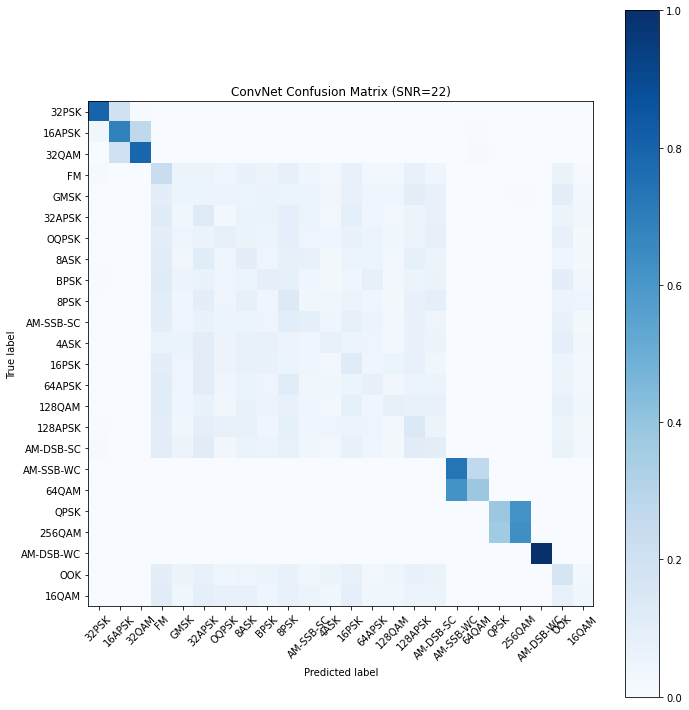

<Figure size 432x288 with 0 Axes>

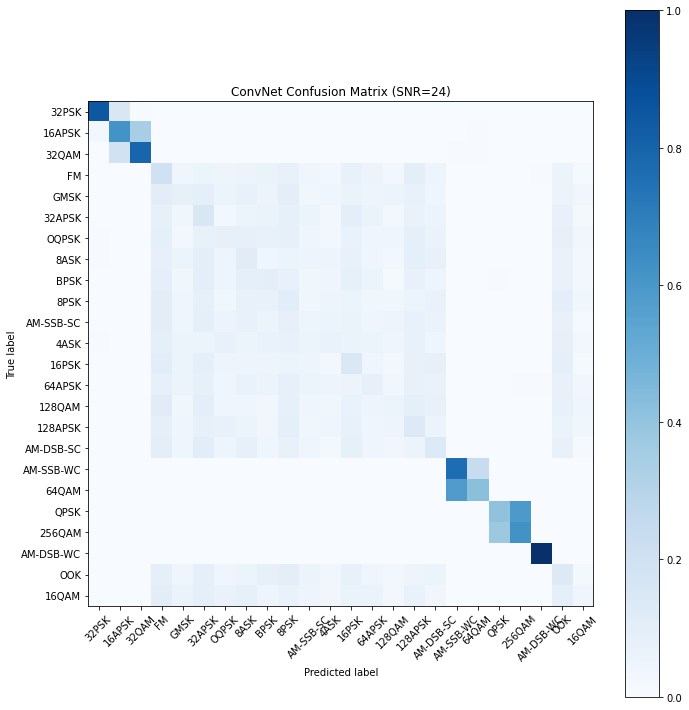

<Figure size 432x288 with 0 Axes>

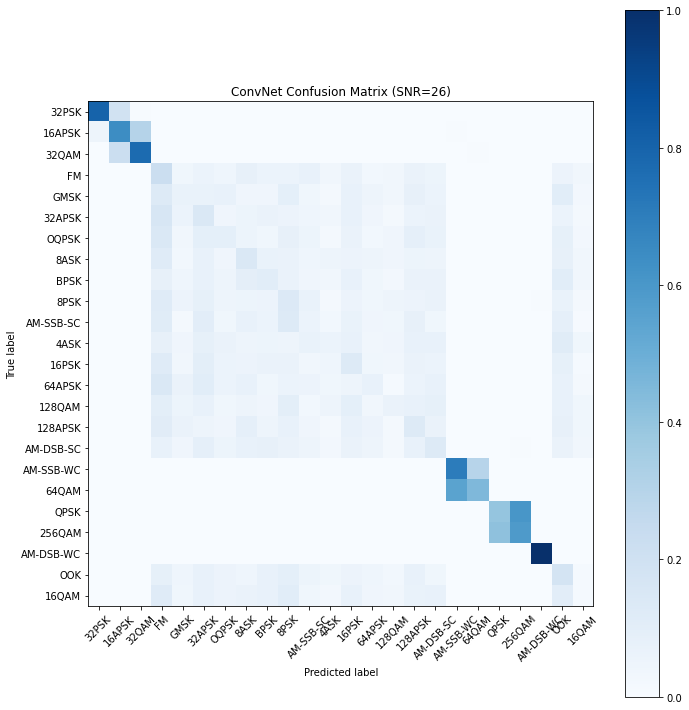

<Figure size 432x288 with 0 Axes>

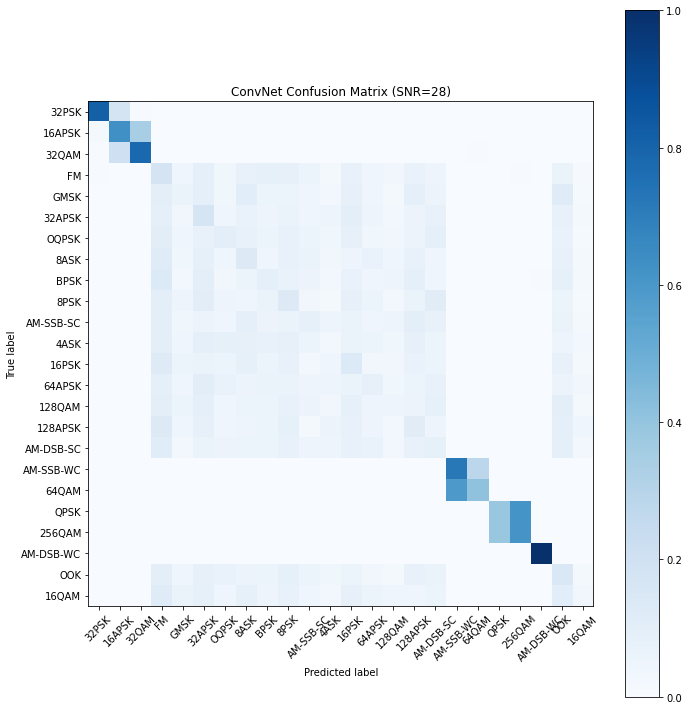

<Figure size 432x288 with 0 Axes>

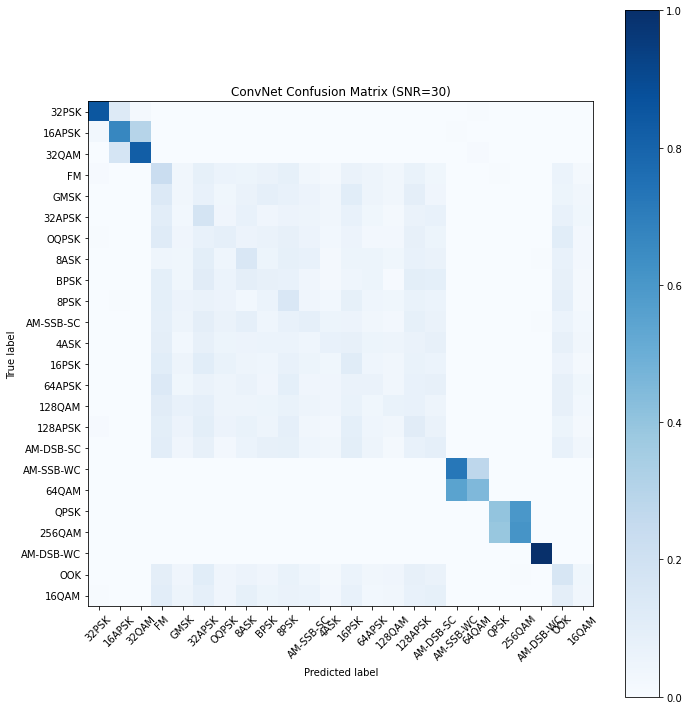

In [41]:

acc={}
Z_test = Z[test_idx]
Z_test = Z_test.reshape((len(Z_test)))
SNRs = np.unique(Z_test)
for snr in SNRs:
    X_test_snr = X_test[Z_test==snr]
    Y_test_snr = Y_test[Z_test==snr]
    
    pre_Y_test = model.predict(X_test_snr)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,X_test_snr.shape[0]):    #该信噪比下测试数据量
        j = list(Y_test_snr[i,:]).index(1)   #正确类别下标
        k = int(np.argmax(pre_Y_test[i,:])) #预测类别下标
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
   
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy %s: "%snr, cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

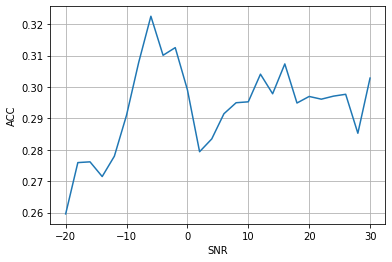

In [42]:

plt.plot(acc.keys(),acc.values())
plt.ylabel('ACC')
plt.xlabel('SNR')
plt.grid(True)
plt.show()